<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/intro/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch

In this notebook, we show a few simple examples of how to use PyTorch.

**Make sure you select 'GPU' from the 'Runtime' tab at the top of this page.**

For more details, see 


* [The official pytorch tutorials](https://pytorch.org/tutorials/)
* [The incredible pytorch](https://github.com/ritchieng/the-incredible-pytorch), an extensive list of PyTorch tutorials
* [This course from Udacity](https://github.com/udacity/deep-learning-v2-pytorch).


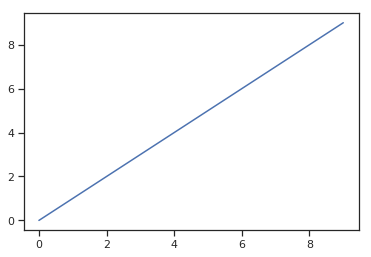

In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
np.set_printoptions(precision=3)
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

# Check we can plot stuff
plt.figure()
plt.plot(range(10))

In [0]:
# We can make some wrappers around random number generation
# so it works even if we switch from numpy to JAX
import numpy as onp # original numpy

def set_seed(seed):
    onp.random.seed(seed)
    
def randn(*args):
    return onp.random.randn(*args)
        
def randperm(args):
    return onp.random.permutation(args)

In [2]:
# Pytorch
import torch
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("Torch cannot find GPU")

torch version 1.1.0
Tesla T4


## MLP applied to MNIST

The MLP code is based 
[this udacity example](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution.ipynb)

For a CNN version, see [this official pytorch example](https://github.com/pytorch/examples/blob/master/mnist/main.py)



In [0]:
# Download data

from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20856430.82it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 332694.16it/s]
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5275931.41it/s]                           
8192it [00:00, 130941.13it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


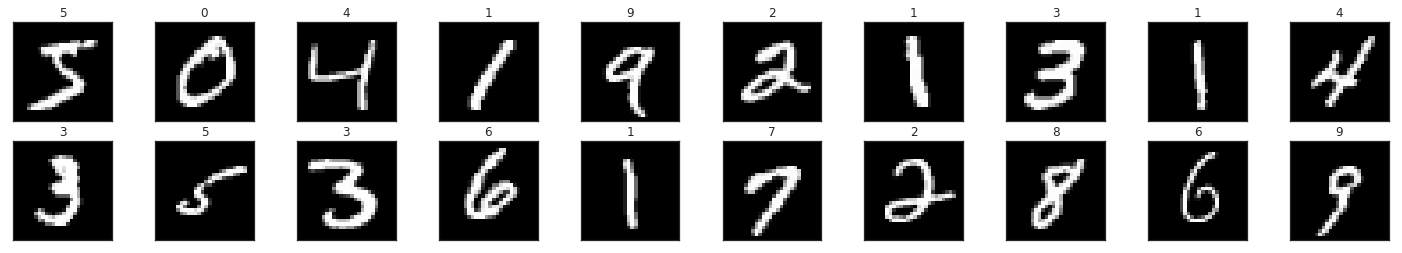

In [0]:
# Visualize data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

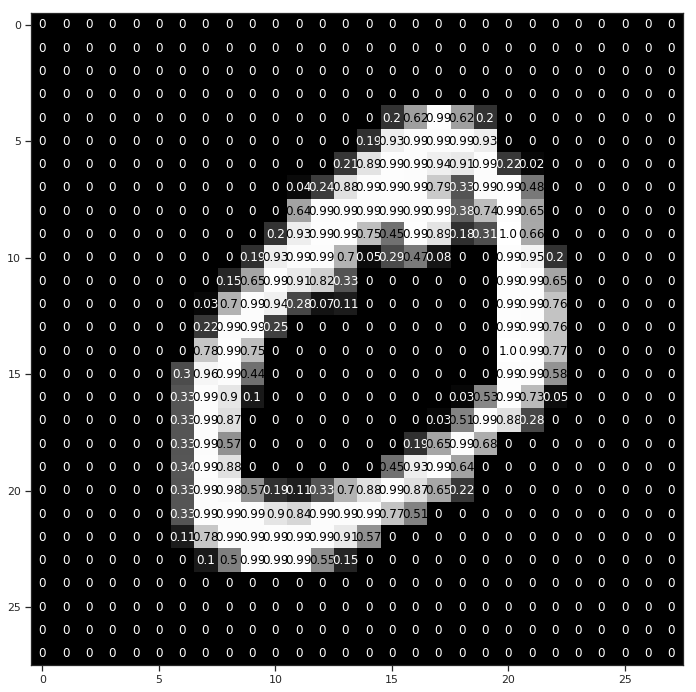

In [0]:
# View a single image as a 2d array

img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [0]:
# Create a 2 layer MLP with fully connected layers.
# We optionally add dropout regularization.

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, use_dropout=False):
        super(Net, self).__init__()
        hidden_1 = 64
        hidden_2 = 64
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.2)
           
            
    def forward(self, x):
        x = x.view(-1, 28 * 28) # flatten image input to 784 dim vector
        x = F.relu(self.fc1(x))
        if self.use_dropout: x = self.dropout(x)
        x = F.relu(self.fc2(x))
        if self.use_dropout: x = self.dropout(x)
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [0]:
# PyTorch does not have a handy 'fit' function, unlike Keras.
# (Although skorch (https://skorch.readthedocs.io/en/stable/), does provide this.)
# Below we write the training loop manually.

n_epochs = 5 # Faster, and causes models to have test errors (which is more interesting to look at :)

model.train() # prep model for training

# specify loss function (categorical cross-entropy, which takes logits as input)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
             
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.859247
Epoch: 2 	Training Loss: 0.325310
Epoch: 3 	Training Loss: 0.269676
Epoch: 4 	Training Loss: 0.231975
Epoch: 5 	Training Loss: 0.201253


In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.191383

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 90% (938/1032)
Test Accuracy of     3: 93% (945/1010)
Test Accuracy of     4: 94% (930/982)
Test Accuracy of     5: 93% (836/892)
Test Accuracy of     6: 94% (906/958)
Test Accuracy of     7: 92% (953/1028)
Test Accuracy of     8: 90% (883/974)
Test Accuracy of     9: 94% (952/1009)

Test Accuracy (Overall): 94% (9422/10000)


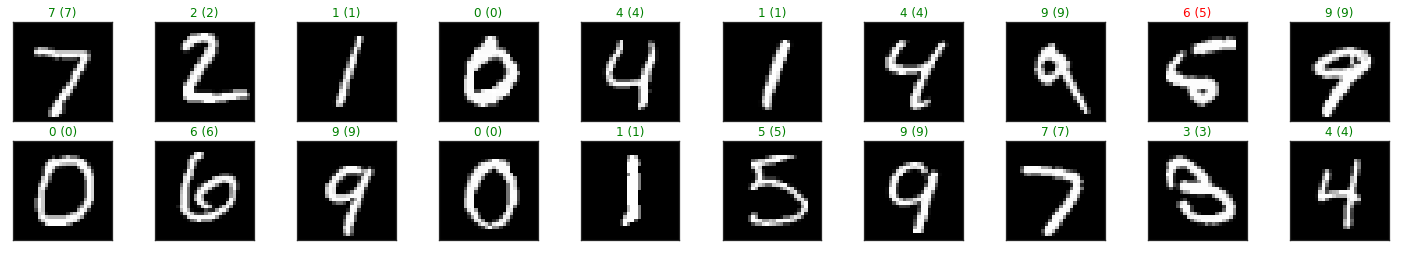

In [0]:
# Visualize test examples.
# Title has the format of predicted-label (true-label) for each image.
# Green = correct, red = incorrect.

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# PyTorch datasets

When dealing with large datasets, it is useful to read the data in parallel.
Fortunately PyTorch already has code for this which is easy to use, as we show below.


In [9]:
from torch.utils.data import DataLoader, TensorDataset

set_seed(0)
N_train = 5
D = 4               
X = randn(N_train, D)
y = randn(N_train)
batch_size = 2
print('all labels')
print(y)

train_set = TensorDataset(torch.Tensor(X), torch.Tensor(y))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) 

print("One epoch")
for step, (x,y) in enumerate(train_loader):
    print(y)
    

all labels
[-2.553  0.654  0.864 -0.742  2.27 ]
One epoch
tensor([-2.5530,  0.6536])
tensor([ 0.8644, -0.7422])
tensor([2.2698])


The DataLoader will stop once it reaches the end of the dataset. We can convert it to an infinite stream using the code below ([source](https://gist.github.com/MFreidank/821cc87b012c53fade03b0c7aba13958)), written by Moritz Freidank.

In [11]:
class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch
    
train_loader_infinite = InfiniteDataLoader(train_set, batch_size=batch_size, shuffle=False)
step = 0
num_minibatches = 4
for batch in train_loader_infinite:
    x, y = batch
    print(y)
    step = step + 1
    if step >= num_minibatches:
        break

tensor([-2.5530,  0.6536])
tensor([ 0.8644, -0.7422])
tensor([2.2698])
tensor([-2.5530,  0.6536])


Many standard datasets are already in PyTorch format, so we can just pass them to the dataloader. Below we show how to do this for MNIST. (We convert each PIL image to a flat numpy array.)

In [13]:
import torchvision.datasets as datasets

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=np.float32))

mnist_dataset = datasets.MNIST('/tmp/mnist/',  download=True, transform=FlattenAndCast())
training_generator = DataLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

print("MNIST labels")
step = 0
for batch in training_generator:
    if step >= num_minibatches:
        break
    x, y = batch
    y = y.numpy()
    print(y)
    step = step + 1

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 19485351.52it/s]                            


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 338246.33it/s]
0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5911685.15it/s]                           
8192it [00:00, 133147.86it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
MNIST labels
[5 0]
[4 1]
[9 2]
[1 3]
